In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import shap
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score,r2_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

StatementMeta(, 0e901cb8-4967-465c-9ac9-4a9b279ee146, 3, Finished, Available, Finished)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Loading dataset

path = 'Tables/dbo/Student_variables'
df = spark.read.format('Delta').load(path)
df = df.toPandas()
df.head()

StatementMeta(, 0e901cb8-4967-465c-9ac9-4a9b279ee146, 4, Finished, Available, Finished)

,StudentNumber,Age,IsChurchMemberCMIS,lastcompletedactivitydate,canvaslastlogin,Num_Courses,Dropped_Courses,avg_percentage_score,courses_under_80,HDI_rank,Human_Development_Index_HDI_2023,is_enrolled_next_term
0,13037354,0.284390,1,2.0,2.0,2.393462,-0.155645,-2.023592,4.038602,0.974165,-0.997194,0
1,13114999,-0.646181,1,4.0,2.0,2.393462,-0.155645,-1.075635,4.038602,0.535189,-0.432137,1
2,20093469,-0.646181,1,7.0,2.0,2.393462,-0.155645,-2.495396,4.038602,0.827840,-0.823331,0
3,20141699,-0.739238,1,4.0,2.0,2.393462,-0.155645,-1.939869,4.038602,1.250558,-1.413225,1
4,20142643,-0.180895,1,4.0,2.0,2.393462,-0.155645,-2.242958,4.038602,0.762806,-0.723980,0


In [3]:
# Defining Features and Labels

# After Checking feature importance was discovered many columns are not relevant
df = df.drop(columns= ['Human_Development_Index_HDI_2023','Dropped_Courses'])
target_column = 'is_enrolled_next_term'
X = df.drop(columns= ['StudentNumber',target_column])
y = df[target_column]

StatementMeta(, 0e901cb8-4967-465c-9ac9-4a9b279ee146, 5, Finished, Available, Finished)

In [4]:
# Spliting dataset into Train/Test

X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size= 0.2, random_state=42 ,stratify=y) # stritify make equal distribution on each split

StatementMeta(, 0e901cb8-4967-465c-9ac9-4a9b279ee146, 6, Finished, Available, Finished)

In [5]:
# Training the model

sample_weights = compute_sample_weight('balanced', y_train) # load balance on y_train

modelo = GradientBoostingClassifier()
modelo.fit(X_train,y_train, sample_weight = sample_weights)
y_pred =  modelo.predict(X_test)
y_prob_1 =  modelo.predict_proba(X_test)[:,1]    
y_prob_0 =  modelo.predict_proba(X_test)[:,0] 

StatementMeta(, 0e901cb8-4967-465c-9ac9-4a9b279ee146, 7, Finished, Available, Finished)

StatementMeta(, 0e901cb8-4967-465c-9ac9-4a9b279ee146, 8, Finished, Available, Finished)

AUC: 0.8662
AUC: 0.8662

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.76      0.70      4486
           1       0.89      0.83      0.86     10503

    accuracy                           0.81     14989
   macro avg       0.77      0.80      0.78     14989
weighted avg       0.82      0.81      0.81     14989



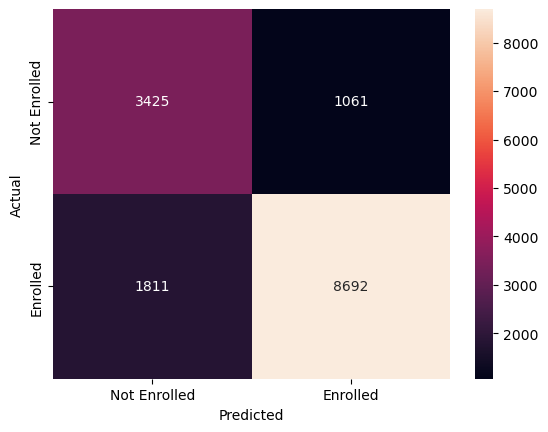

In [6]:
# Evaluation
auc = roc_auc_score(y_test, y_prob_1)
print(f"AUC: {auc:.4f}")
auc_class_0_inverse = roc_auc_score(y_test, y_prob_0)
auc_class_0 = 1 - auc_class_0_inverse
print(f"AUC: {auc_class_0:.4f}")


print('\nClassification Report:')
print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test,y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['Not Enrolled', 'Enrolled']

sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Feature importance

StatementMeta(, 241e7a6d-94c5-4934-be8f-03dd2555727d, 9, Finished, Available, Finished)

                     feature  importance
2  lastcompletedactivitydate    0.650262
3            canvaslastlogin    0.230296
5       avg_percentage_score    0.078513
4                Num_Courses    0.015729
7                   HDI_rank    0.010791
6           courses_under_80    0.006732
1         IsChurchMemberCMIS    0.004894
0                        Age    0.002782


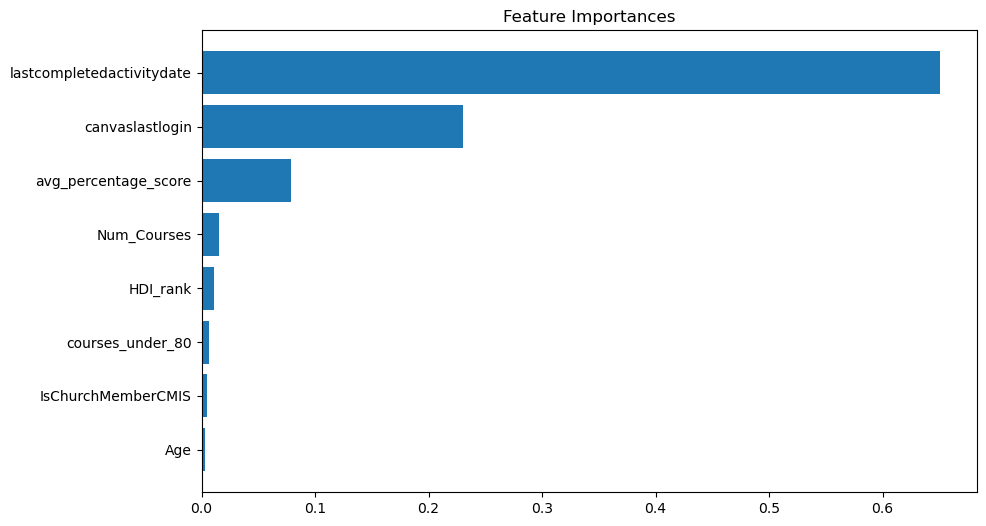

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


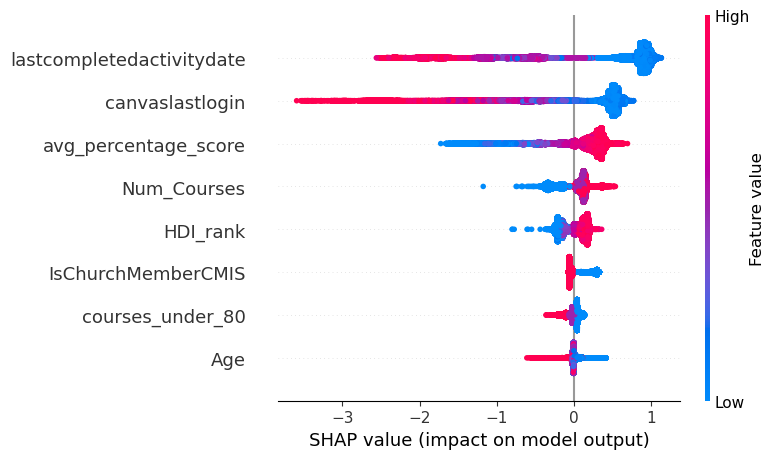

In [7]:
# Importance of features
importances = modelo.feature_importances_
features = X_train.columns

# Df for visual
feat_df = pd.DataFrame({'feature': features, 'importance': importances})
feat_df = feat_df.sort_values(by='importance', ascending=False)

print(feat_df)

# Visualization
plt.figure(figsize=(10,6))
plt.barh(feat_df['feature'], feat_df['importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importances")
plt.show()

explainer = shap.TreeExplainer(modelo)
shap_values = explainer.shap_values(X_train)

# Caso 1: shap_values es lista (binario o multiclase)
if isinstance(shap_values, list):
    shap_values_class0 = shap_values[0]  # contribuciones clase 0
else:
    # Caso 2: shap_values es un solo array (binario con diferencia implícita)
    shap_values_class0 = shap_values

# Aseguramos que tenga la forma correcta
if len(shap_values_class0.shape) == 1:
    shap_values_class0 = shap_values_class0.reshape(-1, X_train.shape[1])

# Ahora sí graficamos
shap.summary_plot(shap_values_class0, X_train)

Threshold adjustment

StatementMeta(, 241e7a6d-94c5-4934-be8f-03dd2555727d, 10, Finished, Available, Finished)

Best Threshold for Recall over class 0 is
 threshold           0.990000
presicion_class0    0.277120
recall_class0       0.897459
f1_class0           0.423477
Name: 99, dtype: float64
Best Threshold for F1 over class 0 is
 threshold           0.990000
presicion_class0    0.277120
recall_class0       0.897459
f1_class0           0.423477
Name: 99, dtype: float64


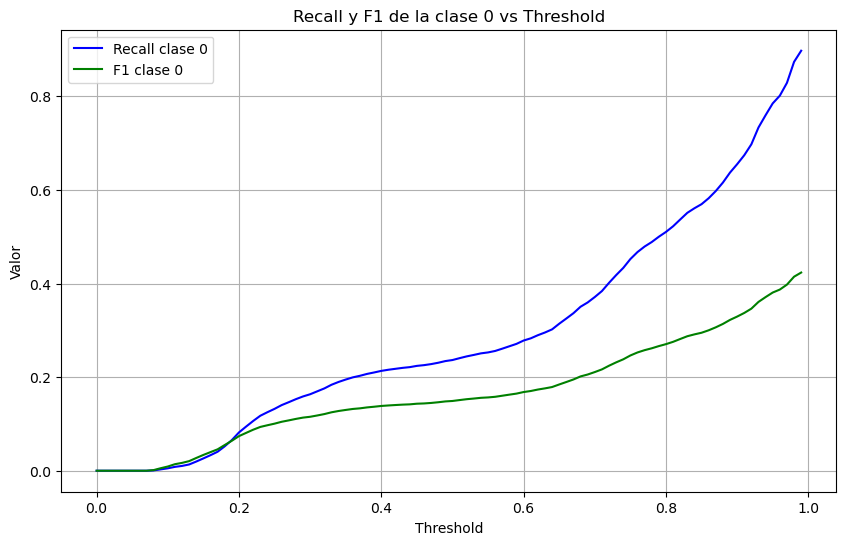

In [8]:
import numpy as np
from sklearn.metrics import classification_report

# Test different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
for threshold in thresholds:
    # Classify based on the new threshold
    y_pred_new = np.where(y_prob_0 > threshold, 0, 1)

    # Print the classification report for this threshold
    print(f"--- Threshold: {threshold:.2f} ---")
    print(classification_report(y_test, y_pred_new))

# After reviewing the reports, select the best threshold
best_threshold = 0.18 # example
final_y_pred = np.where(y_prob_0 > best_threshold, 0, 1)

# Plot
plt.figure(figsize=(10,6))
plt.plot(df_result["threshold"], df_result["recall_class0"], label="Recall clase 0", color="blue")
plt.plot(df_result["threshold"], df_result["f1_class0"], label="F1 clase 0", color="green")
plt.xlabel("Threshold")
plt.ylabel("Valor")
plt.title("Recall y F1 de la clase 0 vs Threshold")
plt.grid(True)
plt.legend()
plt.show()



#### not posible to use SMOTE


In [ ]:
threshold = np.arange(0,1,0.01) # generate the values where the threshold will be evaluated
results = [] # empty list where the results of each threshold will be saved

for t in threshold:
    y_pred = (y_prob_0 >= t).astype(int) # depending on probability under the threshold they will become 0 or 1
    precision, recall, F1, _ = precision_recall_fscore_support(
        y_test, y_pred, average=None, labels= [0,1], zero_division=0
    )
    results.append({
        "threshold": t,
        "presicion_class0": precision[0],
        "recall_class0": recall[0],
        "f1_class0": F1[0]
    })

# converting the list into df 
df_result = pd.DataFrame(results)

# Plot
plt.figure(figsize=(10,6))
plt.plot(df_result["threshold"], df_result["recall_class0"], label="Recall clase 0", color="blue")
plt.plot(df_result["threshold"], df_result["f1_class0"], label="F1 clase 0", color="green")
plt.xlabel("Threshold")
plt.ylabel("Valor")
plt.title("Recall y F1 de la clase 0 vs Threshold")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# 1. Separar datos (asumiendo que X y y ya están definidos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Entrenar el modelo
sample_weights = compute_sample_weight('balanced', y_train) # load balance on y_train

modelo = GradientBoostingClassifier()
modelo.fit(X_train,y_train, sample_weight = sample_weights)
y_pred =  modelo.predict(X_test)
y_prob_1 =  modelo.predict_proba(X_test)[:,1]    
y_prob_0 =  modelo.predict_proba(X_test)[:,0]  

# 3. Obtener las probabilidades de la clase 0 para el conjunto de prueba
y_prob_0 = modelo.predict_proba(X_test)[:, 0]

# 4. Definir tu umbral óptimo (ej. 0.20, basado en el análisis anterior)
best_threshold = 0.3

# 5. Aplicar el umbral para obtener las predicciones finales
y_pred_final = np.where(y_prob_0 > best_threshold, 0, 1)

# Evaluation
auc = roc_auc_score(y_test, y_pred_final)
print(f"AUC_1: {auc:.4f}")
auc_class_0_inverse = roc_auc_score(y_test, y_prob_0)
auc_class_0 = 1 - auc_class_0_inverse
print(f"AUC_0: {auc_class_0:.4f}")

# 6. Evaluar el rendimiento con el nuevo umbral
print(classification_report(y_test, y_pred_final))

cm2 = confusion_matrix(y_test,y_pred_final)

import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['Not Enrolled', 'Enrolled']

sns.heatmap(cm2, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()